# House Price Predictor

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# -----------------------------
# 1. Load the dataset
# -----------------------------
# Replace 'house_prices.csv' with the path to your dataset.
data = pd.read_csv('train.csv')
#data

In [3]:
# -----------------------------
# 2. Data Cleaning
# -----------------------------
# Select only numeric columns that have no missing data.
numeric_cols = data.select_dtypes(include=[np.number]).columns
clean_numeric_cols = [col for col in numeric_cols if data[col].isna().sum() == 0]
data_clean = data[clean_numeric_cols]

# Ensure that the target column 'price' is present.
if 'SalePrice' not in data_clean.columns:
    raise ValueError("The target column 'price' is not present in the complete numeric data.")

In [4]:
# -----------------------------
# 3. Feature Selection
# -----------------------------
# Compute the correlation matrix using only the cleaned numeric data.
corr_matrix = data_clean.corr()

# Compute absolute correlations of features with the target and drop the target itself.
target_corr = corr_matrix['SalePrice'].drop('SalePrice').abs().sort_values(ascending=False)

# Select only the top 4 features with the highest correlation with 'SalesPrice'
top4_features = target_corr.head(4).index
print("Selected top 4 features:", list(top4_features))

# Define input features (X) and target variable (y).
X = data_clean[top4_features].values
y = data_clean['SalePrice'].values.reshape(-1, 1)

Selected top 4 features: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea']


In [5]:
# -----------------------------
# 4. Data Preprocessing
# -----------------------------
# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features to improve training stability.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# Convert the numpy arrays to PyTorch tensors.
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create a TensorDataset and DataLoader for batch processing.
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [8]:
class AdvancedHousePriceModel(nn.Module):
    def __init__(self, input_dim):
        super(AdvancedHousePriceModel, self).__init__()
        # Increase capacity by having a wide first layer.
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        
        # Second layer: Reduce dimensionality gradually.
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        
        # Third layer: Further reduce.
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        
        # Fourth layer: More abstraction.
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        
        # Output layer for regression.
        self.fc5 = nn.Linear(32, 1)
        
        # Activation and dropout settings.
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Increased dropout to help prevent overfitting.
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc5(x)
        return x

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HousePriceModel(input_dim=X_train.shape[1]).to(device)

In [10]:
# -----------------------------
# 6. Set Up Loss Function, Optimizer, and Scheduler
# -----------------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, verbose=True)

# -----------------------------
# 7. Train the Model with Validation and Gradient Clipping
# -----------------------------
num_epochs = 1000
best_val_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item() * batch_X.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    
    # Evaluate on validation (test) set every 10 epochs
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_predictions = model(X_test_tensor.to(device))
            val_loss = criterion(val_predictions, y_test_tensor.to(device)).item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")
        
        # Step the scheduler based on the validation loss
        scheduler.step(val_loss)
        
        # Optionally, implement early stopping:
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # Optionally, save the best model weights
            best_model_wts = model.state_dict()
        # Uncomment below to add a simple early stopping condition
        # else:
        #     early_stop_counter += 1
        #     if early_stop_counter >= patience_threshold:
        #         print("Early stopping")
        #         break

# Optionally, load the best model weights after training is complete.
# model.load_state_dict(best_model_wts)


/home/codespace/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/1000], Training Loss: 1391339228.1600, Validation Loss: 941371072.0000
Epoch [20/1000], Training Loss: 1390334278.4000, Validation Loss: 933337472.0000
Epoch [30/1000], Training Loss: 1389200787.2000, Validation Loss: 936893248.0000
Epoch [40/1000], Training Loss: 1387732093.4400, Validation Loss: 940617792.0000
Epoch [50/1000], Training Loss: 1388083543.0400, Validation Loss: 936843008.0000
Epoch [60/1000], Training Loss: 1387297937.9200, Validation Loss: 936262720.0000
Epoch [70/1000], Training Loss: 1386624120.3200, Validation Loss: 934910720.0000
Epoch [80/1000], Training Loss: 1385170936.3200, Validation Loss: 930924608.0000
Epoch [90/1000], Training Loss: 1384211420.1600, Validation Loss: 928221120.0000
Epoch [100/1000], Training Loss: 1385365420.8000, Validation Loss: 933413184.0000
Epoch [110/1000], Training Loss: 1382955069.4400, Validation Loss: 938585216.0000
Epoch [120/1000], Training Loss: 1383866068.4800, Validation Loss: 936465792.0000
Epoch [130/1000], Trainin

In [11]:
# 8. Evaluate the Model
# -----------------------------
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor.to(device))
    test_loss = criterion(predictions, y_test_tensor.to(device)).item()
    print("Test Mean Squared Error:", test_loss)

# Optionally, to evaluate using scikit-learn's MSE:
predictions_np = predictions.cpu().numpy()
mse = mean_squared_error(y_test, predictions_np)
print("Test MSE (scikit-learn):", mse)
#Test Mean Squared Error: 935741376.0
#Test Mean Squared Error: 890287168.0
#Test MSE (scikit-learn): 890287040.0

Test Mean Squared Error: 902281472.0
Test MSE (scikit-learn): 902281472.0


In [12]:
model.eval()
with torch.no_grad():
    train_predictions = model(X_train_tensor.to(device))
    train_loss = criterion(train_predictions, y_train_tensor.to(device)).item()
    train_rmse = np.sqrt(train_loss)
    print("Training RMSE:", train_rmse)

rmse = np.sqrt(test_loss)
print(f"Test RMSE: {rmse}")


Training RMSE: 36735.61672273926
Test RMSE: 30038.0004660763


/tmp/ipykernel_9603/3042700335.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  errors = np.abs(predictions - y_test)


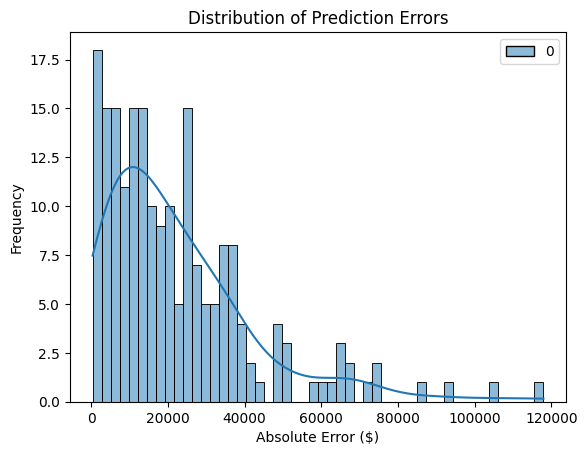

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

errors = np.abs(predictions - y_test)
sns.histplot(errors, bins=50, kde=True)
plt.xlabel("Absolute Error ($)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()

In [14]:
# -----------------------------
# 9. Generate Predictions on New Test Data (test.csv)
# -----------------------------
# Load the new test data
test_data = pd.read_csv('test.csv')

# Ensure the test data contains the ID column and the same top4_features.
# For this example, assume the test file contains an "ID" column.
if 'Id' not in test_data.columns:
    raise ValueError("The test data must contain an 'ID' column.")

# It's assumed that the test data has at least the columns used in training.
# Use the same top4_features determined from the training set.
X_new = test_data[top4_features].values

# Apply the same scaling transformation using the previously fitted scaler.
X_new_scaled = scaler.transform(X_new)

# Convert to PyTorch tensor.
X_new_tensor = torch.tensor(X_new_scaled, dtype=torch.float32).to(device)

# Put the model in evaluation mode and generate predictions.
model.eval()
with torch.no_grad():
    new_predictions = model(X_new_tensor)
    
# Convert predictions to numpy array and flatten if necessary.
new_predictions_np = new_predictions.cpu().numpy().flatten()

# Create a DataFrame with IDs and their corresponding predicted sale prices.
predictions_df = pd.DataFrame({
    'ID': test_data['Id'],
    'SalePrice': new_predictions_np
})

# Save the DataFrame to a CSV file.
predictions_df.to_csv('predictions.csv', index=False)
print("Predictions saved to predictions.csv")


Predictions saved to predictions.csv
